<a href="https://colab.research.google.com/github/karanidenis/Chat-Bot/blob/main/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import json
import pickle
import torch
import random
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/BreastCancerChatbotDataset.csv")
df.head()

,Questions,Answers,Patterns,Tags,Source
0,NaN,NaN,NaN,NaN,NaN
1,What is breast cancer?,Breast cancer is a malignant tumor that develo...,What precisely is breast cancer. Define breast...,breast cancer,https://www.medscape.com/answers/1947145-15523...
2,What are the signs and symptoms of breast cancer?,"Early breast cancers may be asymptomatic, and ...",What are the indications of breast cancer. Wha...,signs symptoms,https://www.medscape.com/answers/1947145-15523...
3,What is included in the evaluation of breast c...,Evaluation of breast cancer includes the follo...,What is included in a breast cancer evaluation...,evaluation,https://www.medscape.com/answers/1947145-15524...
4,Which physical findings suggest breast cancer?,The following physical findings should raise c...,Which physical signs point to breast cancer. W...,indicative indicators,https://www.medscape.com/answers/1947145-15524...


In [ ]:
df.dropna(inplace=True)
df.head()

,Questions,Answers,Patterns,Tags,Source
1,What is breast cancer?,Breast cancer is a malignant tumor that develo...,What precisely is breast cancer. Define breast...,breast cancer,https://www.medscape.com/answers/1947145-15523...
2,What are the signs and symptoms of breast cancer?,"Early breast cancers may be asymptomatic, and ...",What are the indications of breast cancer. Wha...,signs symptoms,https://www.medscape.com/answers/1947145-15523...
3,What is included in the evaluation of breast c...,Evaluation of breast cancer includes the follo...,What is included in a breast cancer evaluation...,evaluation,https://www.medscape.com/answers/1947145-15524...
4,Which physical findings suggest breast cancer?,The following physical findings should raise c...,Which physical signs point to breast cancer. W...,indicative indicators,https://www.medscape.com/answers/1947145-15524...
5,What features of a palpable lump suggest breas...,If a palpable lump is found and possesses any ...,what is lump. What characteristics of a palpab...,lump palpable,https://www.medscape.com/answers/1947145-15524...


In [ ]:
dict_ = {"intents":[]}

# dict_
questions = None
for ind in df.index:
    ques = df['Questions'][ind].lower()
    ques = ques.replace('?','.')
    ques += df['Patterns'][ind].lower()
    ques = ques.split('.')
    for i, q in enumerate(ques):
        ques[i] = q.strip()
    ans = df['Answers'][ind] + "For more information " + df['Source'][ind]
    dict1 = {'tags': df['Tags'][ind]}
    dict1['patterns'] = ques[:-1]
    dict1['responses'] = ans
    dict_['intents'].append(dict1)

# print(dict_)
print(dict_["intents"][:2])

with open("breastCancer.json", "w") as f:
    f.write(json.dumps(dict_))

[{'tags': 'breast cancer', 'patterns': ['what is breast cancer', 'what precisely is breast cancer', 'define breast cancer', 'explain breast cancer'], 'responses': 'Breast cancer is a malignant tumor that develops from the cells of the breast. It is the most common type of cancer among women in the World. It is most often curable when found early.About 80% of breast cancers start in the ducts.For more information https://www.medscape.com/answers/1947145-155238/what-is-breast-cancer'}, {'tags': 'signs symptoms', 'patterns': ['what are the signs and symptoms of breast cancer', 'what are the indications of breast cancer', 'what are the breast cancer signs and symptoms', 'what breast cancer symptoms and signs are present'], 'responses': 'Early breast cancers may be asymptomatic, and pain and discomfort are typically not present. If a lump is discovered, the following may indicate the possible presence of breast cancer:  Change in breast size or shape, Skin dimpling or skin changes, Recent n

In [ ]:
with open('breastCancer.json') as json_file:
    intents = json.load(json_file)

print(intents)

{'intents': [{'tags': 'breast cancer', 'patterns': ['what is breast cancer', 'what precisely is breast cancer', 'define breast cancer', 'explain breast cancer'], 'responses': 'Breast cancer is a malignant tumor that develops from the cells of the breast. It is the most common type of cancer among women in the World. It is most often curable when found early.About 80% of breast cancers start in the ducts.For more information https://www.medscape.com/answers/1947145-155238/what-is-breast-cancer'}, {'tags': 'signs symptoms', 'patterns': ['what are the signs and symptoms of breast cancer', 'what are the indications of breast cancer', 'what are the breast cancer signs and symptoms', 'what breast cancer symptoms and signs are present'], 'responses': 'Early breast cancers may be asymptomatic, and pain and discomfort are typically not present. If a lump is discovered, the following may indicate the possible presence of breast cancer:  Change in breast size or shape, Skin dimpling or skin chang

In [ ]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):  # Ensure pattern is a string
            pattern = pattern.strip()  # Remove leading/trailing whitespace
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags']))
            if intent['tags'] not in classes:
                classes.append(intent['tags'])
# print(documents)

lemmatizer=WordNetLemmatizer()

words =[lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes=sorted(set(classes))
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [ ]:
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]

    # Tokenize and convert to BERT embeddings
    inputs = tokenizer(pattern, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()

    output_row = label_binarizer.transform([tag])[0]

    training.append((embeddings.flatten(), output_row))

print(training)
# Shuffle and prepare the training data
random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[0]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50
41/41 [==============================] - 1s 5ms/step - loss: 5.1655 - accuracy: 0.0124 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
41/41 [==============================] - 0s 4ms/step - loss: 5.0398 - accuracy: 0.0351 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
41/41 [==============================] - 0s 4ms/step - loss: 4.7977 - accuracy: 0.0763 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 4.4519 - accuracy: 0.0804 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
41/41 [==============================] - 0s 5ms/step - loss: 4.0973 - accuracy: 0.1134 - precision: 0.8333 - recall: 0.0206
Epoch 6/50
41/41 [==============================] - 0s 4ms/step - loss: 3.7436 - accuracy: 0.1443 - precision: 0.7143 - recall: 0.0206
Epoch 7/50
41/41 [==============================] - 0s 4ms/step - loss: 3.3969 - accuracy: 0.2124 - precision: 0.7143 - recall: 0.0309
Epoch 8/50
41/41 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


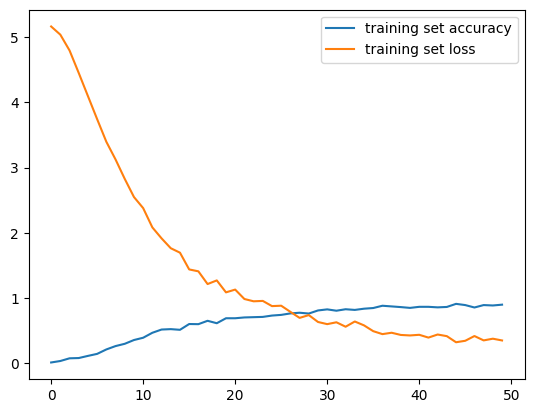

In [ ]:
##plotting model accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],label='training set accuracy')
plt.plot(hist.history['loss'],label='training set loss')
plt.legend()

In [ ]:
# evaluate the model
score = model.evaluate(train_x, train_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07593928277492523
Test accuracy: 0.9814432859420776


In [ ]:

# Predict the classes for the test set
pred_y = model.predict(np.array(train_x))

# Convert predictions and true labels from one-hot encoding to class labels
pred_y_labels = np.argmax(pred_y, axis=1)
test_y_labels = np.argmax(train_y, axis=1)

# Compute accuracy
accuracy = accuracy_score(test_y_labels, pred_y_labels)
print(f"Accuracy: {accuracy}")

# Compute precision, recall, and F1-score
precision = precision_score(test_y_labels, pred_y_labels, average='weighted')
recall = recall_score(test_y_labels, pred_y_labels, average='weighted')
f1 = f1_score(test_y_labels, pred_y_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



16/16 [==============================] - 0s 2ms/step
Accuracy: 0.9814432989690721
Precision: 0.9753983130271789
Recall: 0.9814432989690721
F1 Score: 0.9760324350394888


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Classification report
report = classification_report(test_y_labels, pred_y_labels, target_names=classes)
print(report)

                                                                                      precision    recall  f1-score   support

                                                                    MammaPrint assay       1.00      1.00      1.00         3
                                                                    ductal carcinoma       1.00      1.00      1.00         1
                                                             3D mammography efficacy       1.00      1.00      1.00         1
                                                                      ACP guidelines       0.00      0.00      0.00         1
                                                                      ACR guidelines       1.00      1.00      1.00         1
                                                                      ACS guidelines       0.00      0.00      0.00         1
                                                                 AJCC staging system       1.00      1.00      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.models import load_model

with open('breastCancer.json') as json_file:
    intents = json.load(json_file)

words=pickle.load(open('words.pkl','rb'))
# print(words[:100], len(words))

classes=pickle.load(open('classes.pkl','rb'))
# print(classes[:5], len(classes))
model=load_model('chatbotmodel.h5')


def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings


def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    # print(intents_list[0])
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if tag in i['tags']:
            return i['responses']
    return None

print("GO! BOT IS RUNNING")

while True:
    message=input("")
    if message.lower() in ['quit', 'exit']:
      print("Goodbye")
      break
    ints=predict_class(message)
    if len(ints) > 0:
        res=get_response(ints,intents)
        print(f"Bot: {res}")

GO! BOT IS RUNNING
quit
Goodbye
